In [1]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!gdown --id 1P5qr_xfVBgMYorVCTVJ4X-rLNoO9KYXc

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1P5qr_xfVBgMYorVCTVJ4X-rLNoO9KYXc
To: /content/heypet_dataset.zip
100% 373M/373M [00:09<00:00, 38.1MB/s]


In [4]:
# data processing
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import os, sys
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import seaborn as sns

import os
import shutil

# pretrained models
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

# load models
from keras.models import load_model

# Data preparation

In [10]:
!unzip /content/heypet_dataset.zip -d /content/dataset/

Archive:  /content/heypet_dataset.zip
   creating: /content/dataset/test_dataset/
   creating: /content/dataset/test_dataset/test/
   creating: /content/dataset/test_dataset/test/abyssinian/
  inflating: /content/dataset/test_dataset/test/abyssinian/abyssinian_17.jpg  
  inflating: /content/dataset/test_dataset/test/abyssinian/abyssinian_39673539_198.jpg  
  inflating: /content/dataset/test_dataset/test/abyssinian/abyssinian_40546125_187.jpg  
  inflating: /content/dataset/test_dataset/test/abyssinian/abyssinian_41451716_173.jpg  
  inflating: /content/dataset/test_dataset/test/abyssinian/abyssinian_41664634_170.jpg  
  inflating: /content/dataset/test_dataset/test/abyssinian/abyssinian_42085957_162.jpg  
   creating: /content/dataset/test_dataset/test/americanshorthair/
  inflating: /content/dataset/test_dataset/test/americanshorthair/american shorthair_21.jpg  
  inflating: /content/dataset/test_dataset/test/americanshorthair/american shorthair_88.jpg  
  inflating: /content/dataset/

In [11]:
def visualize_distribution(data_dir):
    x_class = []
    y_total = []
    for i in os.listdir(data_dir):
        path = os.path.join(data_dir, i)
        x_class.append(i)
        y_total.append(len(os.listdir(path)))
    print(x_class)    
    print(y_total)

    plt.figure(figsize=(20,10))
    sns.set_style('darkgrid')
    sns.barplot(x=y_total, y=x_class)
    plt.show()

In [12]:
train_data_dir = '/content/dataset/test_dataset/train/'
val_data_dir = '/content/dataset/test_dataset/val/'
test_data_dir = '/content/dataset/test_dataset/test/'

['persian', 'siamese', 'bulldog', 'goldenretriever', 'abyssinian', 'sphynx', 'chihuahua', 'husky', 'americanshorthair', 'labrador']
[243, 243, 216, 213, 243, 243, 216, 238, 243, 228]


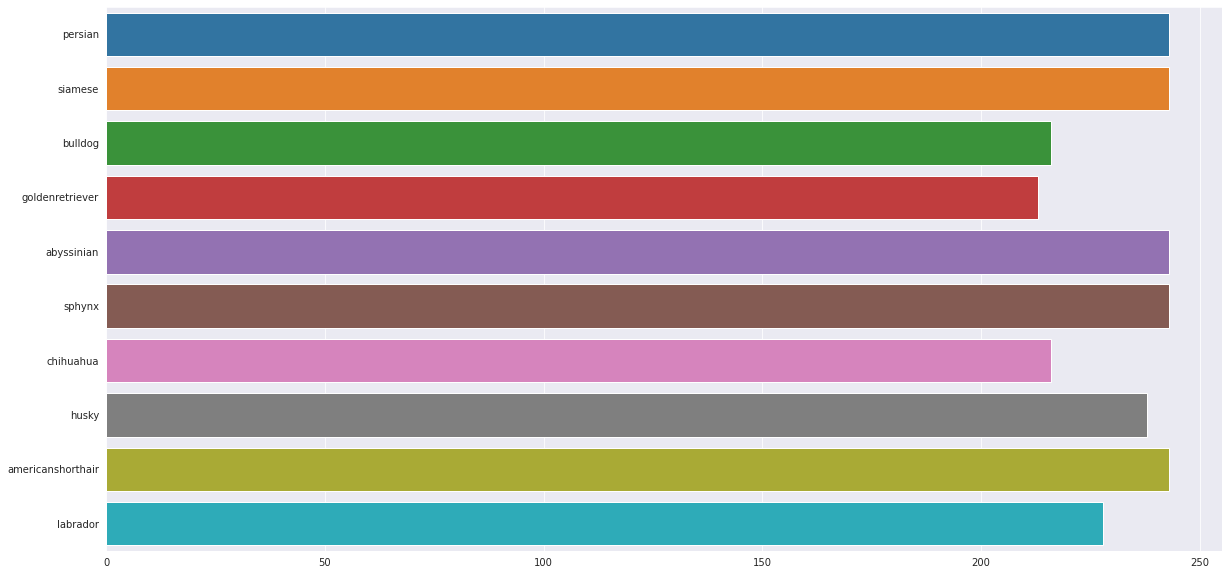

['persian', 'siamese', 'bulldog', 'goldenretriever', 'abyssinian', 'sphynx', 'chihuahua', 'husky', 'americanshorthair', 'labrador']
[21, 21, 19, 18, 21, 21, 19, 21, 21, 20]


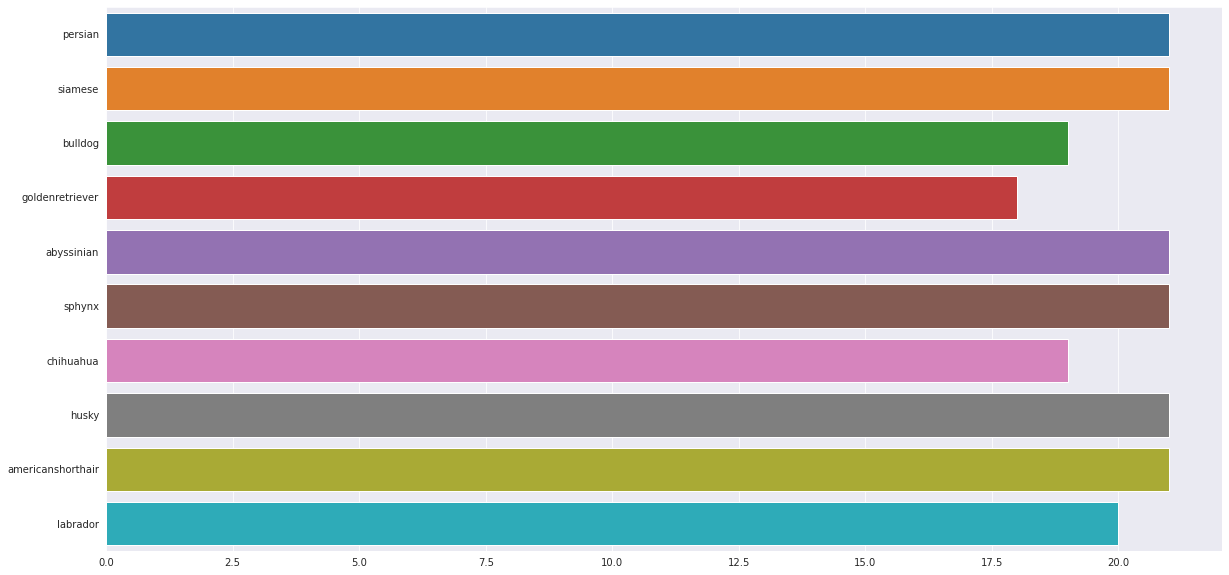

['persian', 'siamese', 'bulldog', 'goldenretriever', 'abyssinian', 'sphynx', 'chihuahua', 'husky', 'americanshorthair', 'labrador']
[6, 6, 5, 6, 6, 6, 6, 6, 6, 6]


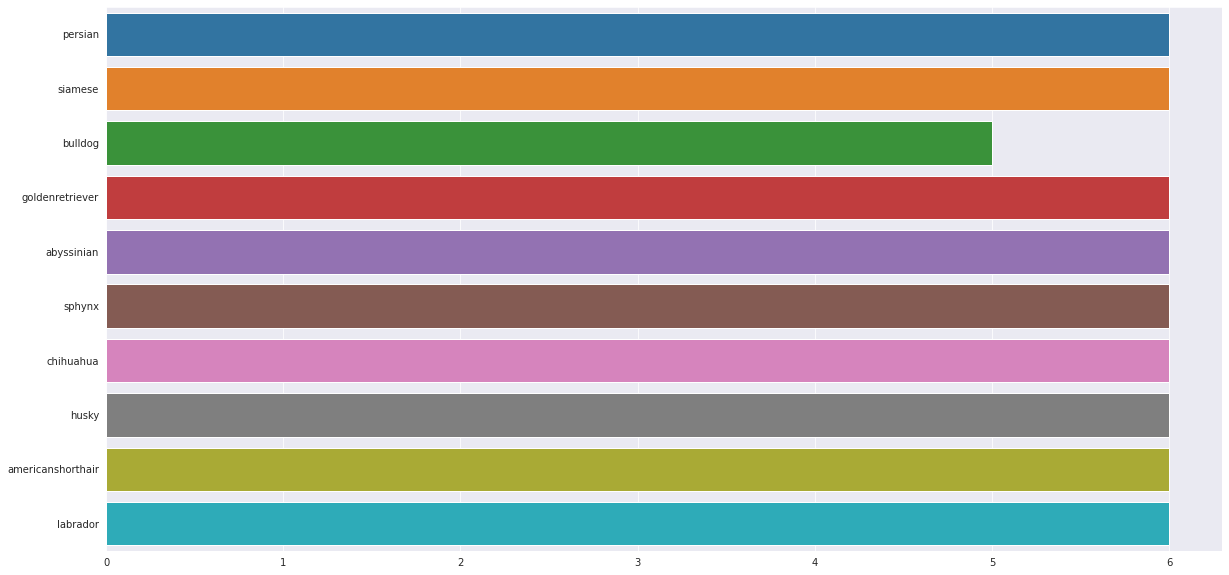

In [13]:
# Check distribution data
visualize_distribution(train_data_dir)
visualize_distribution(val_data_dir)
visualize_distribution(test_data_dir)

In [14]:
def moving_files(source_folder, destination_folder, max_n):
  # data = []
  for file_name in os.listdir(source_folder)[max_n:]:
    source = source_folder + file_name
    destination = destination_folder + file_name
    # print(source, " -> ", destination)
    if os.path.isfile(source):
      # data.append(source)
      shutil.move(source, destination)
  # print(len(data))

for dir in os.listdir(train_data_dir):
  moving_files(train_data_dir+dir+"/", val_data_dir+dir+"/", 213)

for dir in os.listdir(val_data_dir):
  moving_files(val_data_dir+dir+"/", test_data_dir+dir+"/", 18)

['persian', 'siamese', 'bulldog', 'goldenretriever', 'abyssinian', 'sphynx', 'chihuahua', 'husky', 'americanshorthair', 'labrador']
[213, 213, 213, 213, 213, 213, 213, 213, 213, 213]


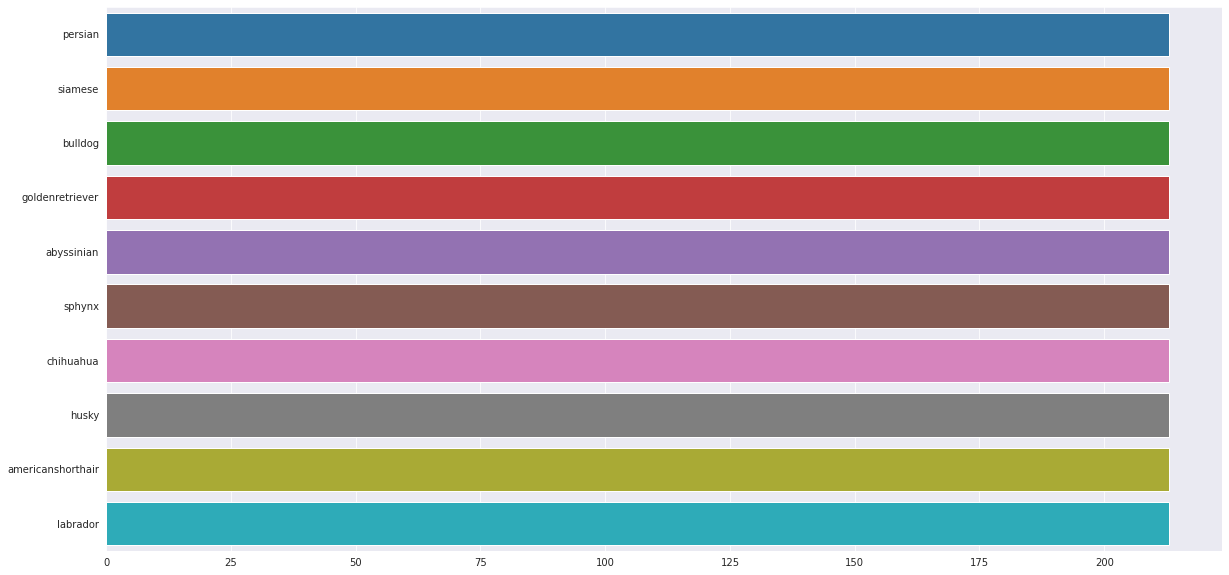

['persian', 'siamese', 'bulldog', 'goldenretriever', 'abyssinian', 'sphynx', 'chihuahua', 'husky', 'americanshorthair', 'labrador']
[18, 18, 18, 18, 18, 18, 18, 18, 18, 18]


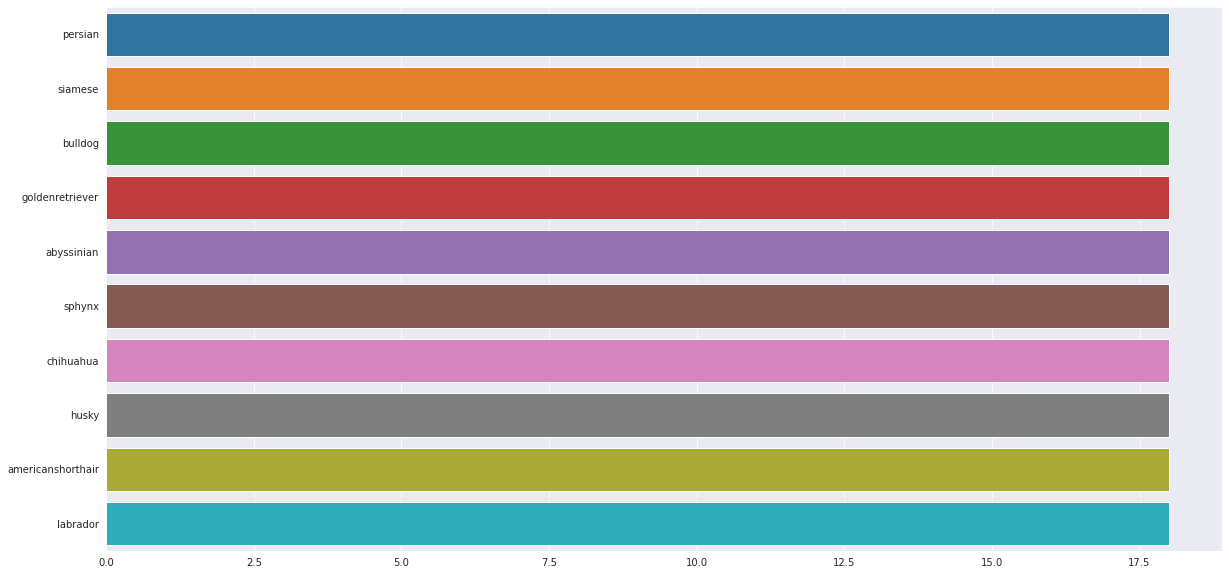

['persian', 'siamese', 'bulldog', 'goldenretriever', 'abyssinian', 'sphynx', 'chihuahua', 'husky', 'americanshorthair', 'labrador']
[39, 39, 9, 6, 39, 39, 10, 34, 39, 23]


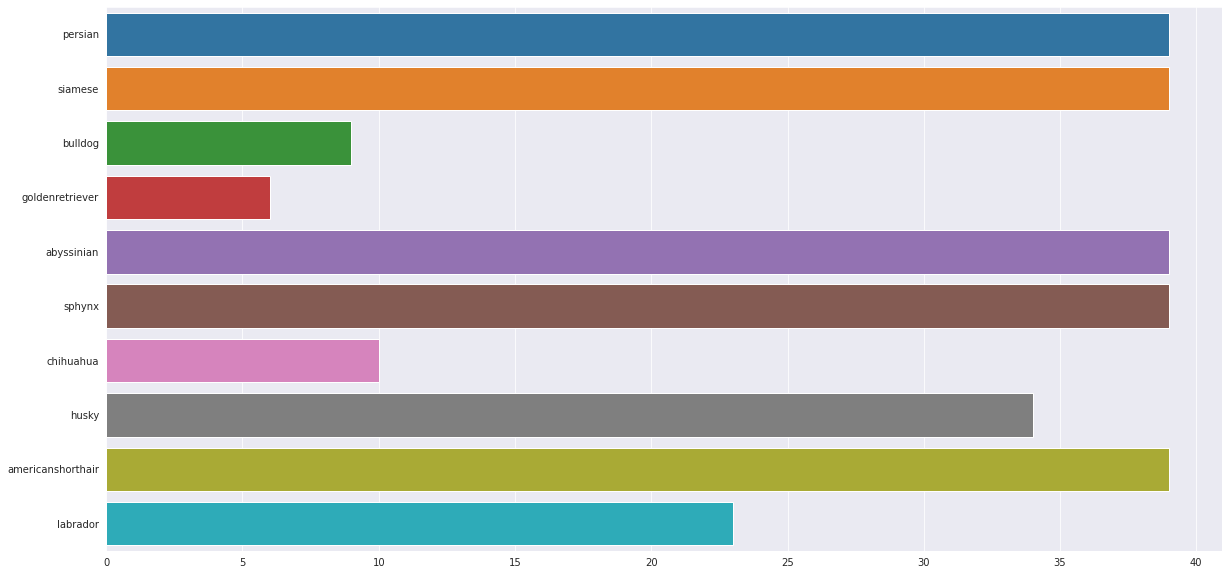

In [15]:
# Check distribution data after formating
visualize_distribution(train_data_dir)
visualize_distribution(val_data_dir)
visualize_distribution(test_data_dir)

# Data preprocessing & generating

In [16]:
# Load dataset, split data, scaling, augmentation
def generate_data_gen(train_dir, val_dir, target_size):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       rotation_range=40, 
                                       width_shift_range=0.2, 
                                       height_shift_range=0.2, 
                                       shear_range=0.2, 
                                       zoom_range=0.2, 
                                       horizontal_flip=True,
                                       vertical_flip=True, 
                                       fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(train_dir, 
                                                        batch_size=32,
                                                        target_size=target_size, 
                                                        class_mode='categorical')
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    batch_size=10,
                                                    target_size=target_size, 
                                                    class_mode='categorical')
    
    return train_generator, val_generator


# get data train and validation
train_generator, val_generator = generate_data_gen(train_data_dir, val_data_dir, (299, 299))

Found 2130 images belonging to 10 classes.
Found 180 images belonging to 10 classes.


# Create model

In [17]:
# Function to visualize the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [18]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

# concate pretrained model and fc layers
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
model.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

# Training model

## Adaptation

Epoch 1/10
67/66 [==============================] - ETA: 0s - loss: 1.4018 - accuracy: 0.5526
Epoch 1: val_accuracy improved from -inf to 0.82778, saving model to /content/models/satu/weights-adapt-01-0.83.h5
66/66 [==============================] - 108s 1s/step - loss: 1.4018 - accuracy: 0.5526 - val_loss: 0.5366 - val_accuracy: 0.8278
Epoch 2/10
67/66 [==============================] - ETA: 0s - loss: 0.7603 - accuracy: 0.7648
Epoch 2: val_accuracy improved from 0.82778 to 0.89444, saving model to /content/models/satu/weights-adapt-02-0.89.h5
66/66 [==============================] - 84s 1s/step - loss: 0.7603 - accuracy: 0.7648 - val_loss: 0.3998 - val_accuracy: 0.8944
Epoch 3/10
67/66 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.7761
Epoch 3: val_accuracy did not improve from 0.89444
66/66 [==============================] - 76s 1s/step - loss: 0.6854 - accuracy: 0.7761 - val_loss: 0.3529 - val_accuracy: 0.8889
Epoch 4/10
67/66 [============================

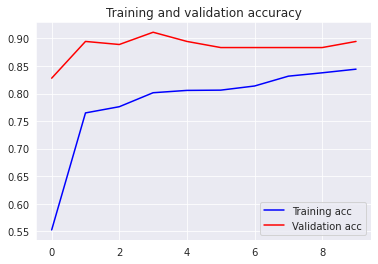

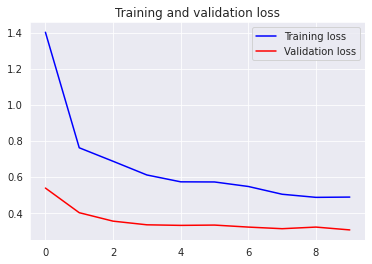

In [19]:
# Freeze the base_model
base_model.trainable = False

# optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# callbacks
filepath = "/content/models/satu/weights-adapt-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# earlystop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
callback_list = [checkpoint]

# train the model on the new data for a few epochs
history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    steps_per_epoch=train_generator.samples/train_generator.batch_size,
                    validation_steps=val_generator.samples/val_generator.batch_size, 
                    epochs=10, 
                    verbose=1, 
                    callbacks=callback_list)

visualize_results(history)

## Finetuning 1

In [20]:
# Freeze top layers and unfreeze end layers
for layer in model.layers[:279]:
   layer.trainable = False
for layer in model.layers[279:]:
   layer.trainable = True

for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

Epoch 1/100
67/66 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.8319
Epoch 1: val_accuracy improved from -inf to 0.89444, saving model to /content/models/satu/weights-fine1-01-0.89.h5
66/66 [==============================] - 82s 1s/step - loss: 0.5436 - accuracy: 0.8319 - val_loss: 0.2993 - val_accuracy: 0.8944
Epoch 2/100
67/66 [==============================] - ETA: 0s - loss: 0.4919 - accuracy: 0.8432
Epoch 2: val_accuracy improved from 0.89444 to 0.90000, saving model to /content/models/satu/weights-fine1-02-0.90.h5
66/66 [==============================] - 76s 1s/step - loss: 0.4919 - accuracy: 0.8432 - val_loss: 0.2991 - val_accuracy: 0.9000
Epoch 3/100
67/66 [==============================] - ETA: 0s - loss: 0.4684 - accuracy: 0.8516
Epoch 3: val_accuracy did not improve from 0.90000
66/66 [==============================] - 76s 1s/step - loss: 0.4684 - accuracy: 0.8516 - val_loss: 0.2935 - val_accuracy: 0.9000
Epoch 4/100
67/66 [=========================

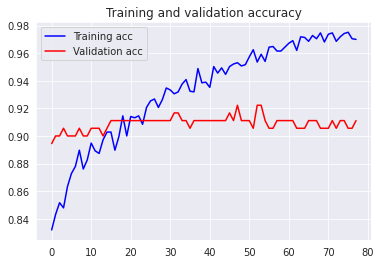

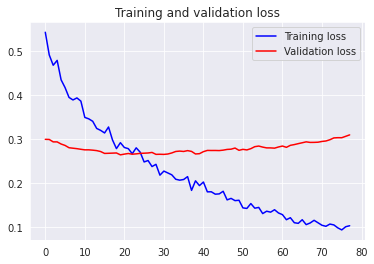

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=["accuracy"])

filepath = "/content/models/satu/weights-fine1-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1)
callback_list = [checkpoint, earlystop]

history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    steps_per_epoch=train_generator.samples/train_generator.batch_size,
                    validation_steps=val_generator.samples/val_generator.batch_size, 
                    epochs=100, 
                    verbose=1,
                    callbacks=callback_list)

visualize_results(history)

## Finetuning 2

In [23]:
model = load_model('/content/models/satu/weights-fine1-48-0.92.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

Epoch 1/50
67/66 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9545
Epoch 1: val_accuracy improved from -inf to 0.92222, saving model to /content/models/satu/weights-fine2-01-0.92.h5
66/66 [==============================] - 81s 1s/step - loss: 0.1562 - accuracy: 0.9545 - val_loss: 0.2767 - val_accuracy: 0.9222
Epoch 2/50
67/66 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9540
Epoch 2: val_accuracy did not improve from 0.92222
66/66 [==============================] - 76s 1s/step - loss: 0.1611 - accuracy: 0.9540 - val_loss: 0.2770 - val_accuracy: 0.9222
Epoch 3/50
67/66 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9507
Epoch 3: val_accuracy did not improve from 0.92222
66/66 [==============================] - 77s 1s/step - loss: 0.1656 - accuracy: 0.9507 - val_loss: 0.2772 - val_accuracy: 0.9222
Epoch 4/50
67/66 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9606
Epoch 4: val_accurac

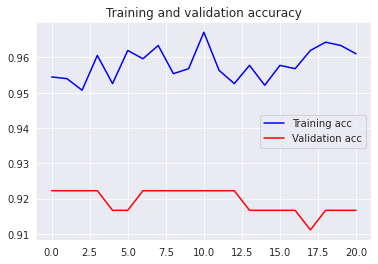

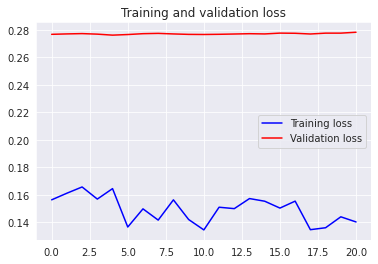

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), 
              loss='categorical_crossentropy', 
              metrics=["accuracy"])

filepath = "/content/models/satu/weights-fine2-{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1)
callback_list = [checkpoint, earlystop]

history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    steps_per_epoch=train_generator.samples/train_generator.batch_size,
                    validation_steps=val_generator.samples/val_generator.batch_size, 
                    epochs=50, 
                    verbose=1,
                    callbacks=callback_list)

visualize_results(history)

# Eval

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_data_dir, 
                                                  target_size=(299, 299), 
                                                  shuffle=False,  
                                                  batch_size=277,
                                                  class_mode='categorical')
x, y = test_generator.next()
print("x: ",len(x)," y: ",len(y))

Found 277 images belonging to 10 classes.
x:  277  y:  277


## Model evaluation

In [26]:
dir_model = '/content/models/satu/weights-fine1-48-0.92.h5'
model = load_model(dir_model)

score = model.evaluate(x, y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.3995579481124878
Test accuracy: 0.8700361251831055


## Confusion Matrix

In [27]:
# predict
pred = model.predict(x)

y_test = []
for i in pred:
    y_test.append(np.argmax(i))

y_pred = []
for i in y:
    y_pred.append(np.argmax(i))

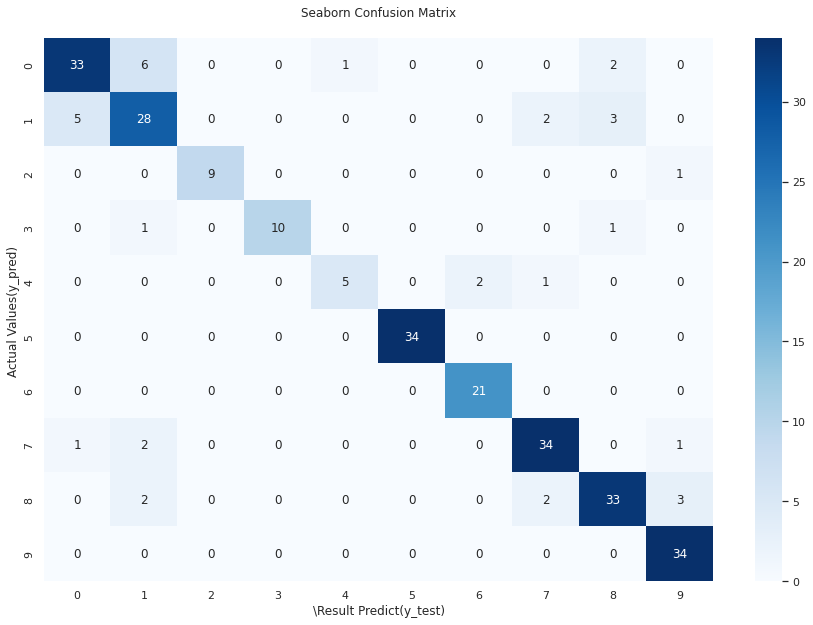

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

sns.set(rc = {'figure.figsize':(15,10)})
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('\Result Predict(y_test)')
ax.set_ylabel('Actual Values(y_pred) ');